# Testing the PET-CT pipeline -- Mainly the training pipeline

Three components:
1. Patient dataset - Defines a dataset which returns paired input-target full volumes of a given patient (index).
2. Patch queue - Combined with a patch sampler, the patch queue creates, stores and returns randomly sampled paired input-target patches of given size.
3. Patch loader - Used with the patch queue to create batches of patches for training.

Note: For visualization purpose, the step for rescaling intensities to unit range in the HECKTORPETCTDataset is disabled to allow viewing using HU and SUV windows.

In [3]:
import os, time

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk
from torch.utils.data import DataLoader
import torchio

import sys
sys.path.append('../')
from datasets.hecktor_petct_dataset import HECKTORPETCTDataset
from datautils.preprocessing import Preprocessor
from datautils.patch_sampling import PatchSampler3D, PatchQueue
from datautils.visualization import NdimageVisualizer, display_image
from datautils.conversion import *

In [4]:
data_dir = "/home/chinmay/Datasets/HECKTOR/hecktor_train/crFHN_rs113_hecktor_nii"
patient_id_filepath = "../hecktor_meta/patient_IDs_train.txt"

preprocessor = Preprocessor()

viz = NdimageVisualizer()

## 1 Testing the dataset class

### 1.1 Separate volume representation

In [3]:
sample_idx = 0

PET_CT_dataset = HECKTORPETCTDataset(data_dir, 
                                     patient_id_filepath, 
                                     mode='training', 
                                     preprocessor=preprocessor,
                                     input_representation='separate-volumes', 
                                     augment_data=False)

sample_dict = PET_CT_dataset[sample_idx]
print(sample_dict['PET'].shape)
print(sample_dict['PET'].min())
print(sample_dict['PET'].max())

# For visualization purpose
PET_np = sample_dict['PET'].squeeze().permute(2,1,0)
CT_np = sample_dict['CT'].squeeze().permute(2,1,0)
target_labelmap_np = sample_dict['target-labelmap'].squeeze().permute(2,1,0)

torch.Size([1, 100, 450, 450])
tensor(0.)
tensor(20.)


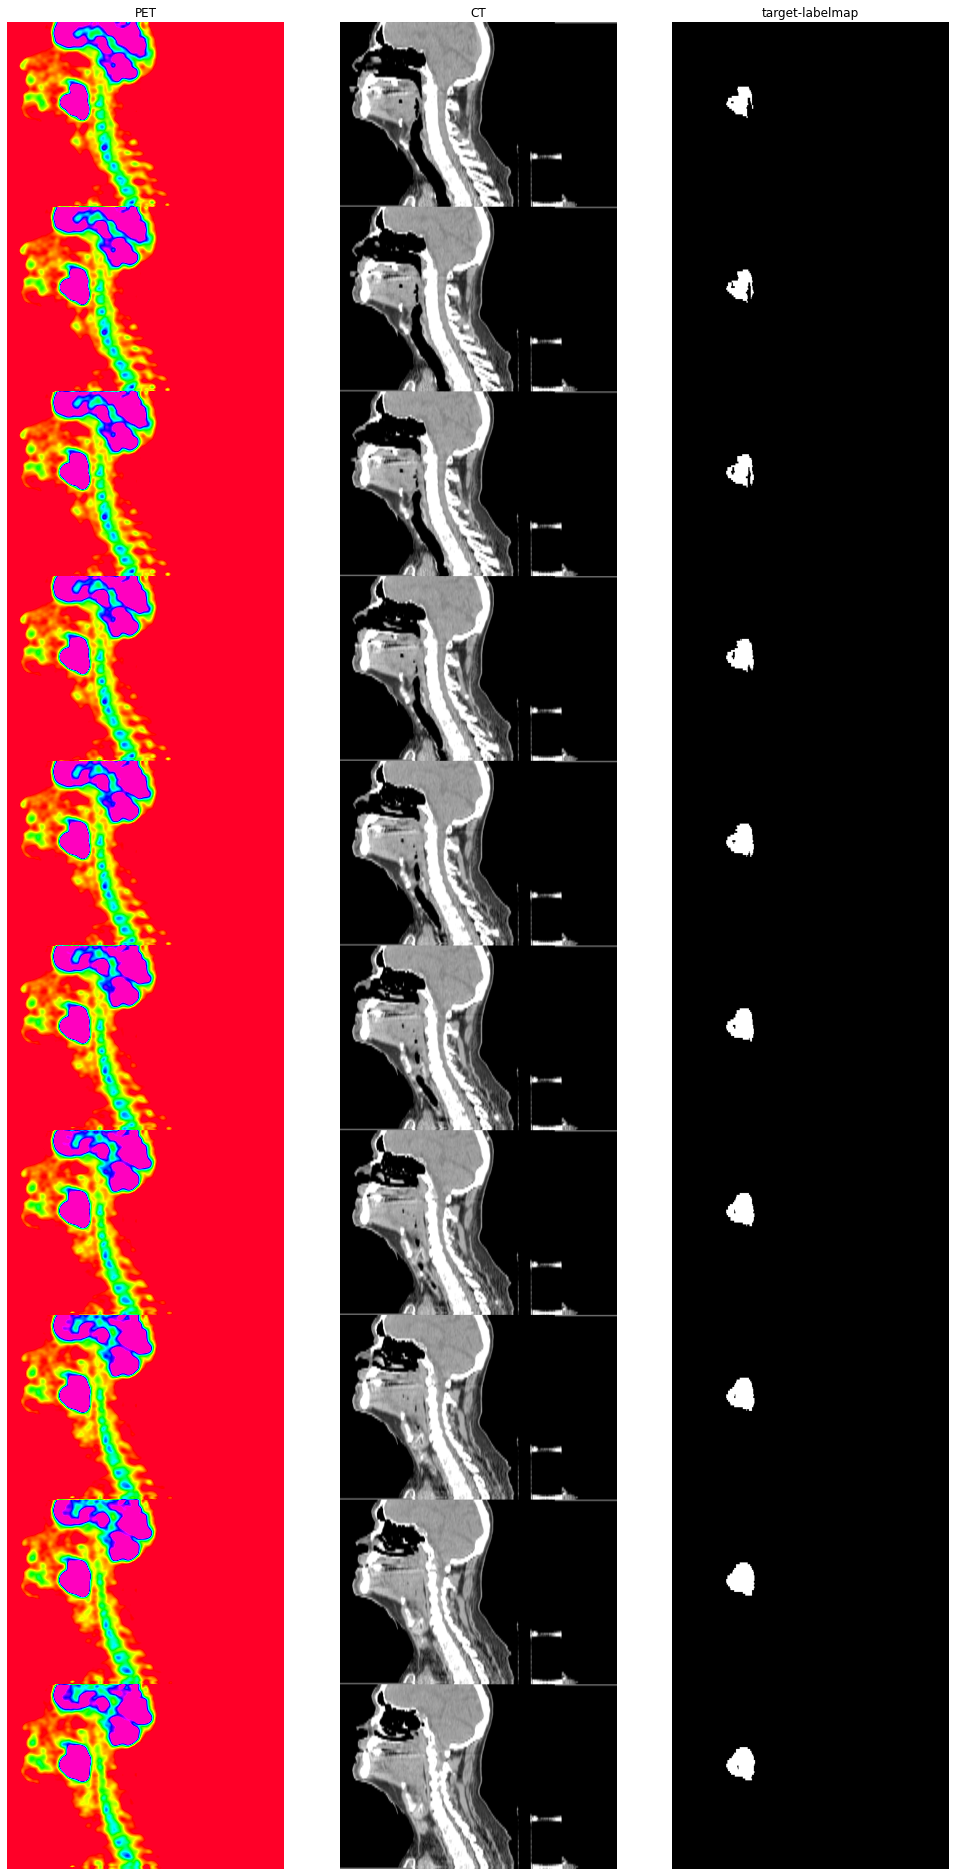

In [4]:
viz.multi_image_strips([PET_np, CT_np, target_labelmap_np],
                          modalities=['PET', 'CT', 'target-labelmap'],
                          idx_range=[230, 240],
                          view='sagittal',
                          subtitles=[])

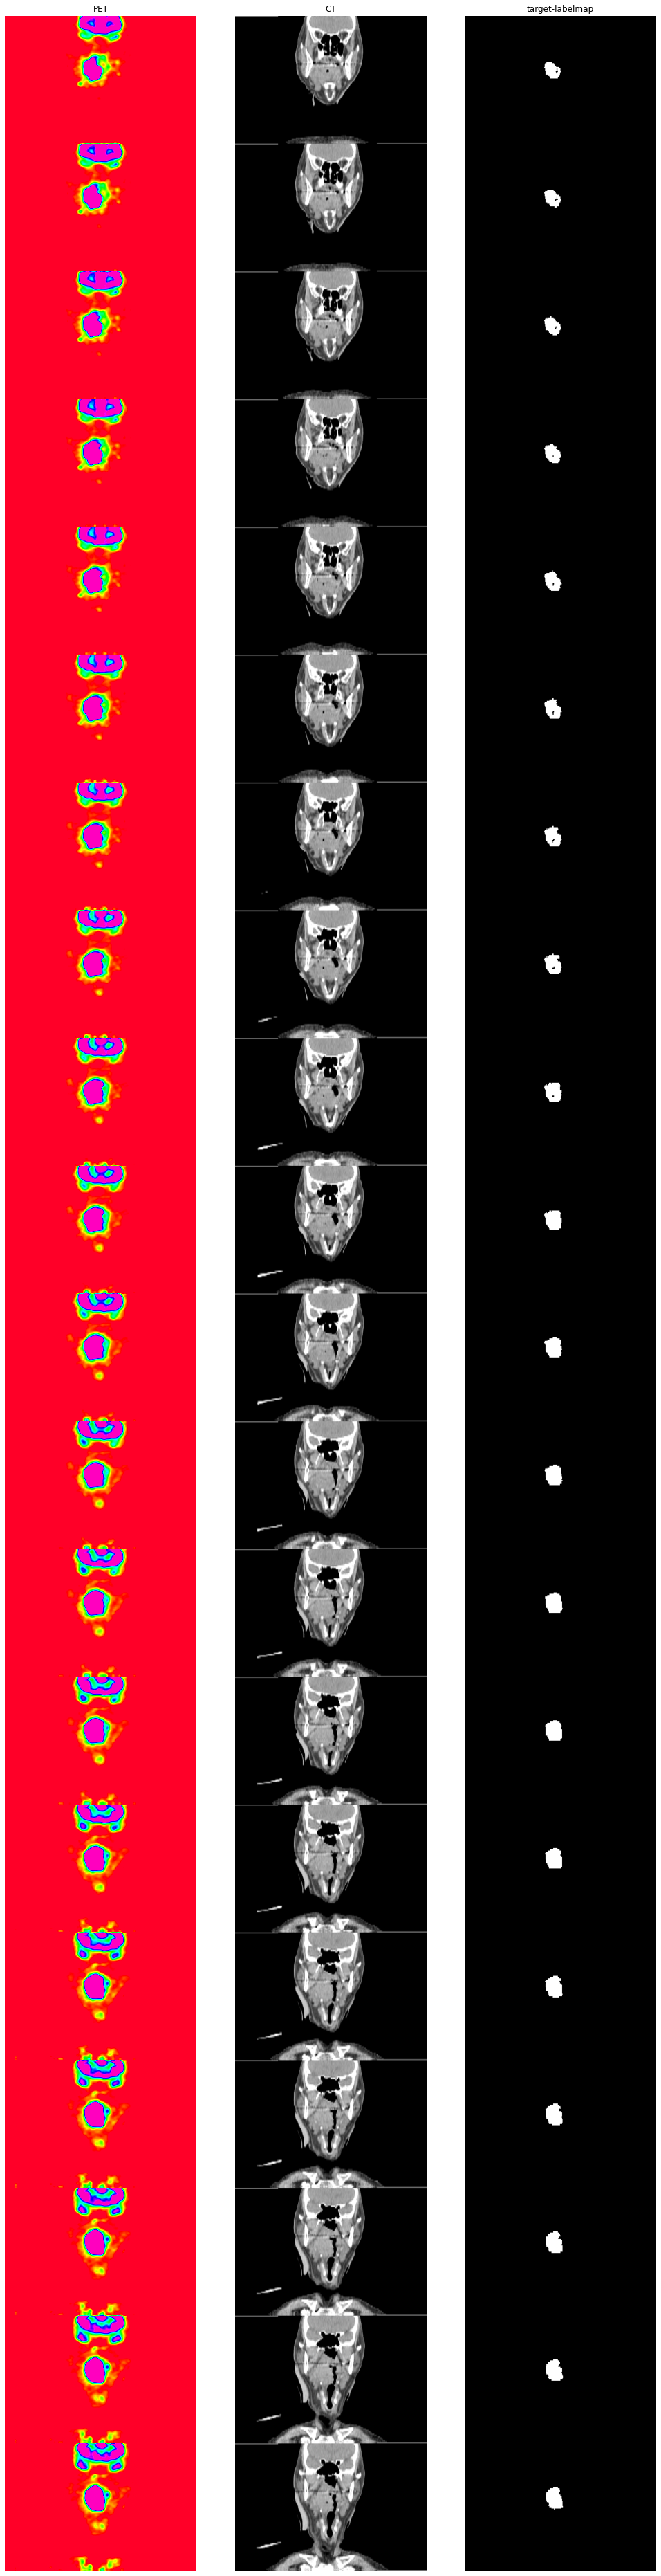

In [5]:
viz.multi_image_strips([PET_np, CT_np, target_labelmap_np],
                          modalities=['PET', 'CT', 'target-labelmap'],
                          idx_range=[100, 120],
                          view='coronal',
                          subtitles=[])

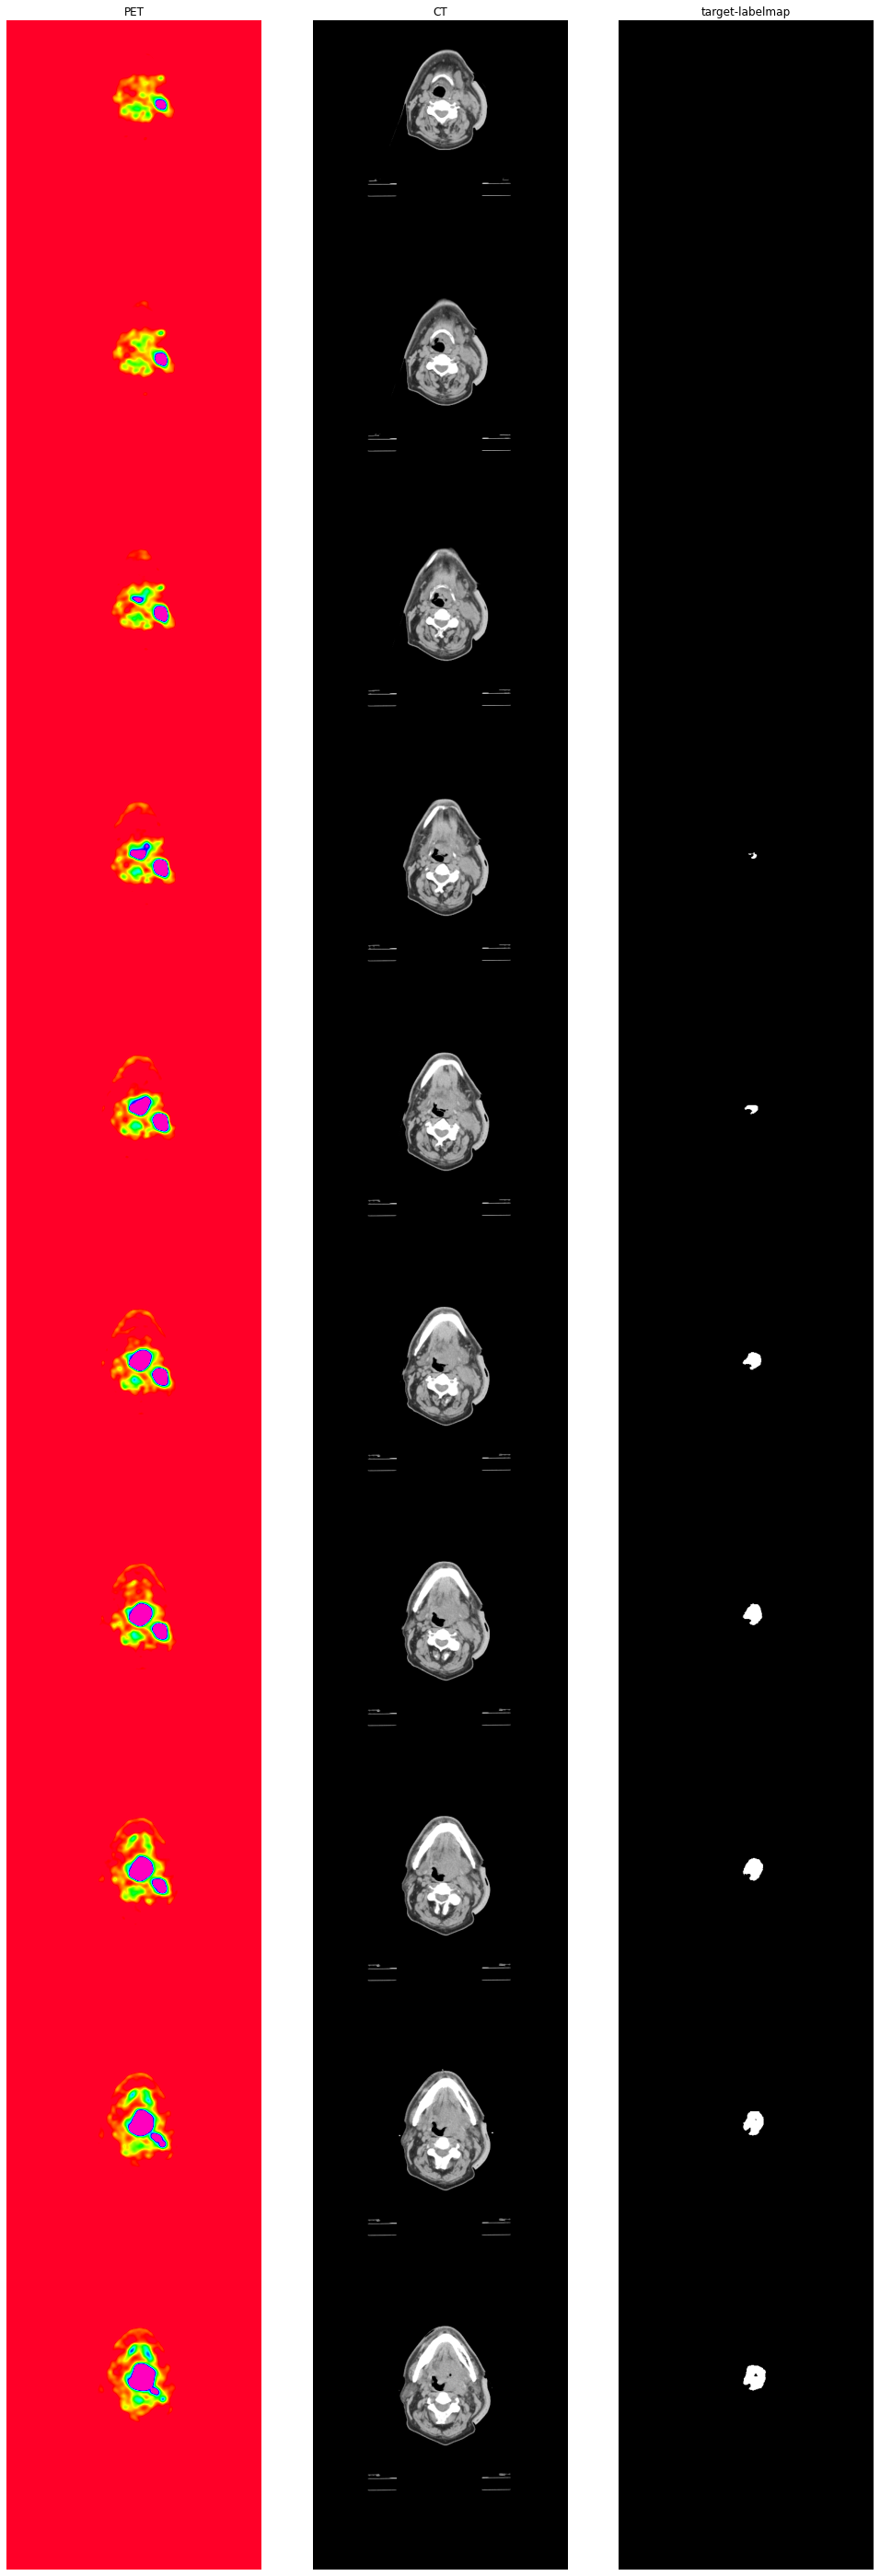

In [6]:
viz.multi_image_strips([PET_np, CT_np, target_labelmap_np],
                          modalities=['PET', 'CT', 'target-labelmap'],
                          idx_range=[45, 55],
                          view='axial',
                          subtitles=[])

### 1.2 Multichannel representation

In [7]:
PET_CT_dataset = HECKTORPETCTDataset(data_dir, 
                                     patient_id_filepath, 
                                     mode='training',
                                     preprocessor=preprocessor,
                                     input_representation='multichannel-volume', 
                                     augment_data=True)

sample_dict = PET_CT_dataset[sample_idx]
print(sample_dict['PET-CT'].shape)

# Extract into separate arrays for visualization
PET_np = sample_dict['PET-CT'].squeeze()[0,:,:,:].permute(2,1,0)
CT_np = sample_dict['PET-CT'].squeeze()[1,:,:,:].permute(2,1,0)
target_labelmap_np = sample_dict['target-labelmap'].squeeze().permute(2,1,0)

torch.Size([2, 100, 450, 450])


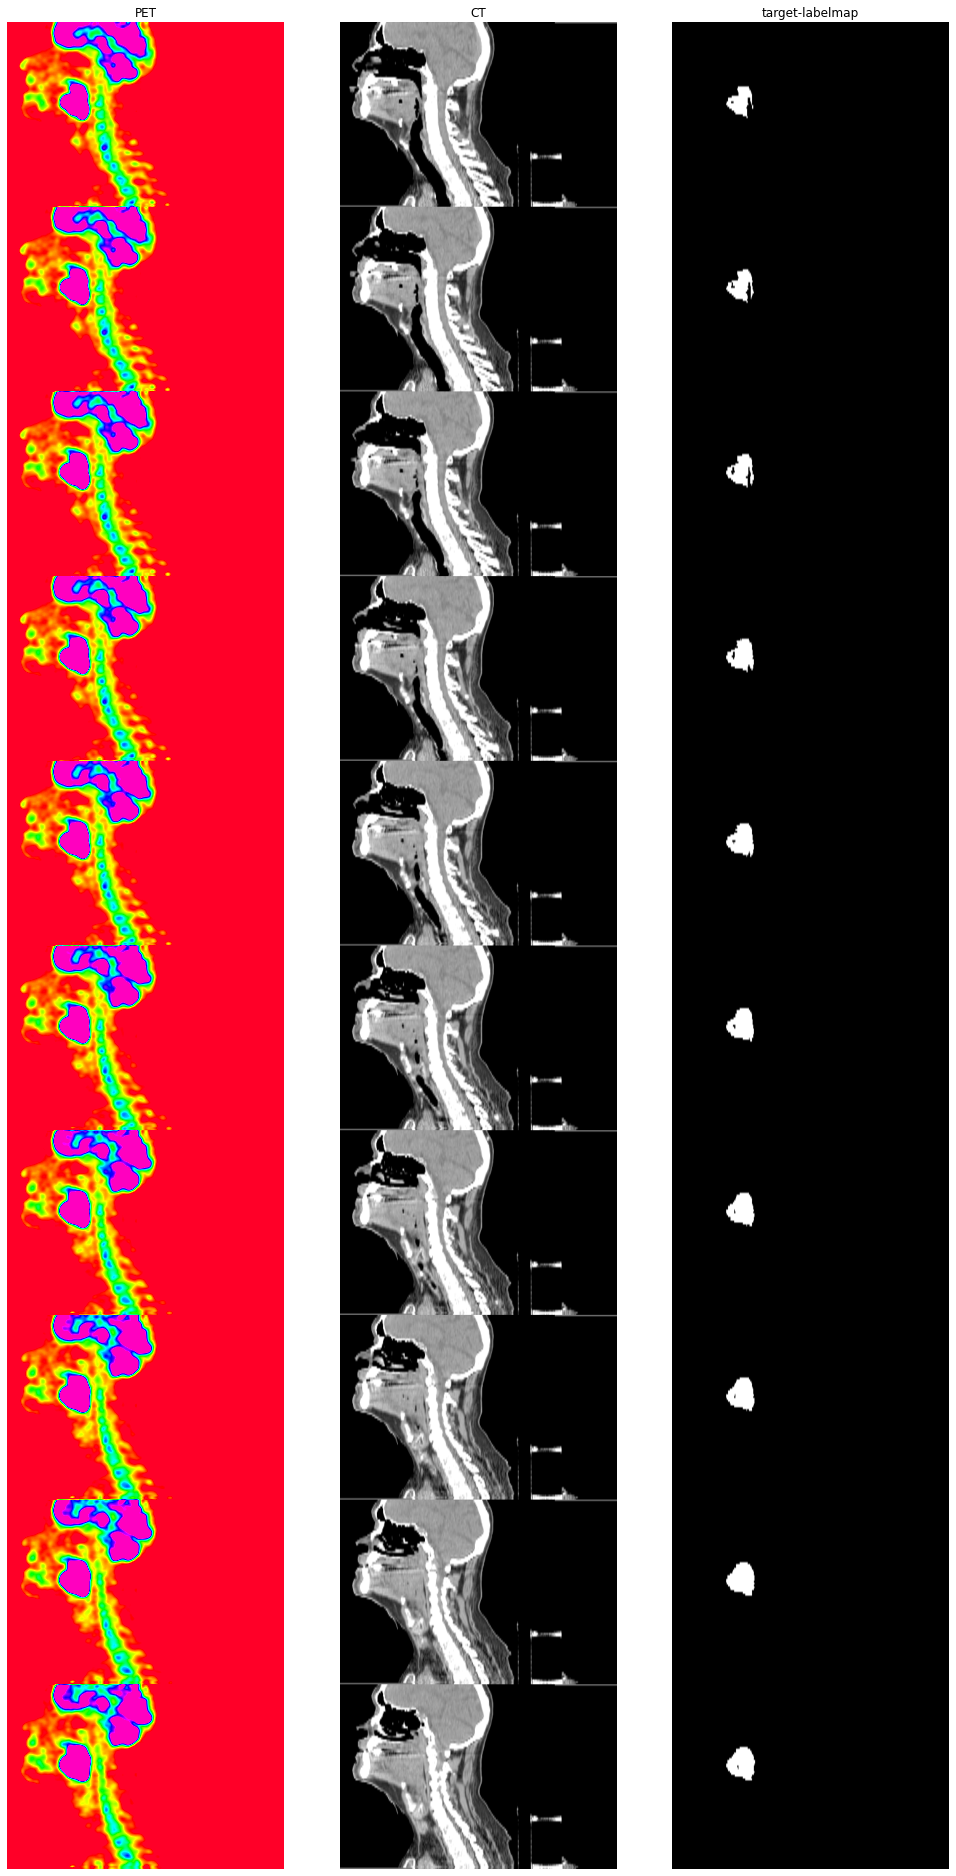

In [8]:
viz.multi_image_strips([PET_np, CT_np, target_labelmap_np],
                          modalities=['PET', 'CT', 'target-labelmap'],
                          idx_range=[230, 240],
                          view='sagittal',
                          subtitles=[])

### 1.3 Cross validation option

In [9]:
available_modes = [
                   'training', 'validation',
                   'cval-CHGJ-training', 'cval-CHGJ-validation',
                   'cval-CHMR-training', 'cval-CHMR-validation',
                   'cval-CHUM-training', 'cval-CHUM-validation',
                   'cval-CHUS-training', 'cval-CHUS-validation'
                  ]

for mode in available_modes:
    PET_CT_dataset = HECKTORPETCTDataset(data_dir, 
                                         patient_id_filepath, 
                                         mode=mode,
                                         preprocessor=preprocessor,
                                         input_representation='separate-volumes', 
                                         augment_data=False)
    print(mode)
    print("Patient data to be used:")
    print(PET_CT_dataset.patient_ids)
    print()

training
Patient data to be used:
['CHGJ007', 'CHGJ008', 'CHGJ010', 'CHGJ013', 'CHGJ015', 'CHGJ016', 'CHGJ017', 'CHGJ018', 'CHGJ025', 'CHGJ026', 'CHGJ028', 'CHGJ029', 'CHGJ030', 'CHGJ031', 'CHGJ032', 'CHGJ034', 'CHGJ035', 'CHGJ036', 'CHGJ037', 'CHGJ038', 'CHGJ039', 'CHGJ043', 'CHGJ046', 'CHGJ048', 'CHGJ050', 'CHGJ052', 'CHGJ053', 'CHGJ055', 'CHGJ057', 'CHGJ058', 'CHGJ062', 'CHGJ065', 'CHGJ066', 'CHGJ067', 'CHGJ069', 'CHGJ070', 'CHGJ071', 'CHGJ072', 'CHGJ073', 'CHGJ074', 'CHGJ076', 'CHGJ077', 'CHGJ078', 'CHGJ080', 'CHGJ081', 'CHGJ082', 'CHGJ083', 'CHGJ085', 'CHGJ086', 'CHGJ087', 'CHGJ088', 'CHGJ089', 'CHGJ090', 'CHGJ091', 'CHGJ092', 'CHMR001', 'CHMR004', 'CHMR005', 'CHMR011', 'CHMR012', 'CHMR013', 'CHMR014', 'CHMR016', 'CHMR020', 'CHMR021', 'CHMR023', 'CHMR024', 'CHMR025', 'CHMR028', 'CHMR029', 'CHMR030', 'CHMR034', 'CHMR040', 'CHUS003', 'CHUS004', 'CHUS005', 'CHUS006', 'CHUS007', 'CHUS008', 'CHUS009', 'CHUS010', 'CHUS013', 'CHUS015', 'CHUS016', 'CHUS019', 'CHUS020', 'CHUS021', 'CHUS022

## 2 Testing the patch queue

In [5]:
preprocessor = Preprocessor()
PET_CT_dataset = HECKTORPETCTDataset(data_dir, 
                                     patient_id_filepath, 
                                     mode='training',
                                     preprocessor=preprocessor,
                                     input_representation='separate-volumes', 
                                     augment_data=False)

In [27]:
# Define the patch sampler and the patch queue

patch_sampler = PatchSampler3D(patch_size=(128,128,32), 
                               volume_size=(450,450,100), 
                               sampling='strided-random',
                               focal_point_stride=(60,60,20)) 

patch_queue = PatchQueue(PET_CT_dataset, 
                         max_length=32, 
                         samples_per_volume=32, 
                         sampler=patch_sampler, 
                         num_workers=0, 
                         shuffle_subjects=False, 
                         shuffle_patches=True)


dict_keys(['PET', 'CT', 'target-labelmap'])
torch.Size([1, 32, 128, 128])


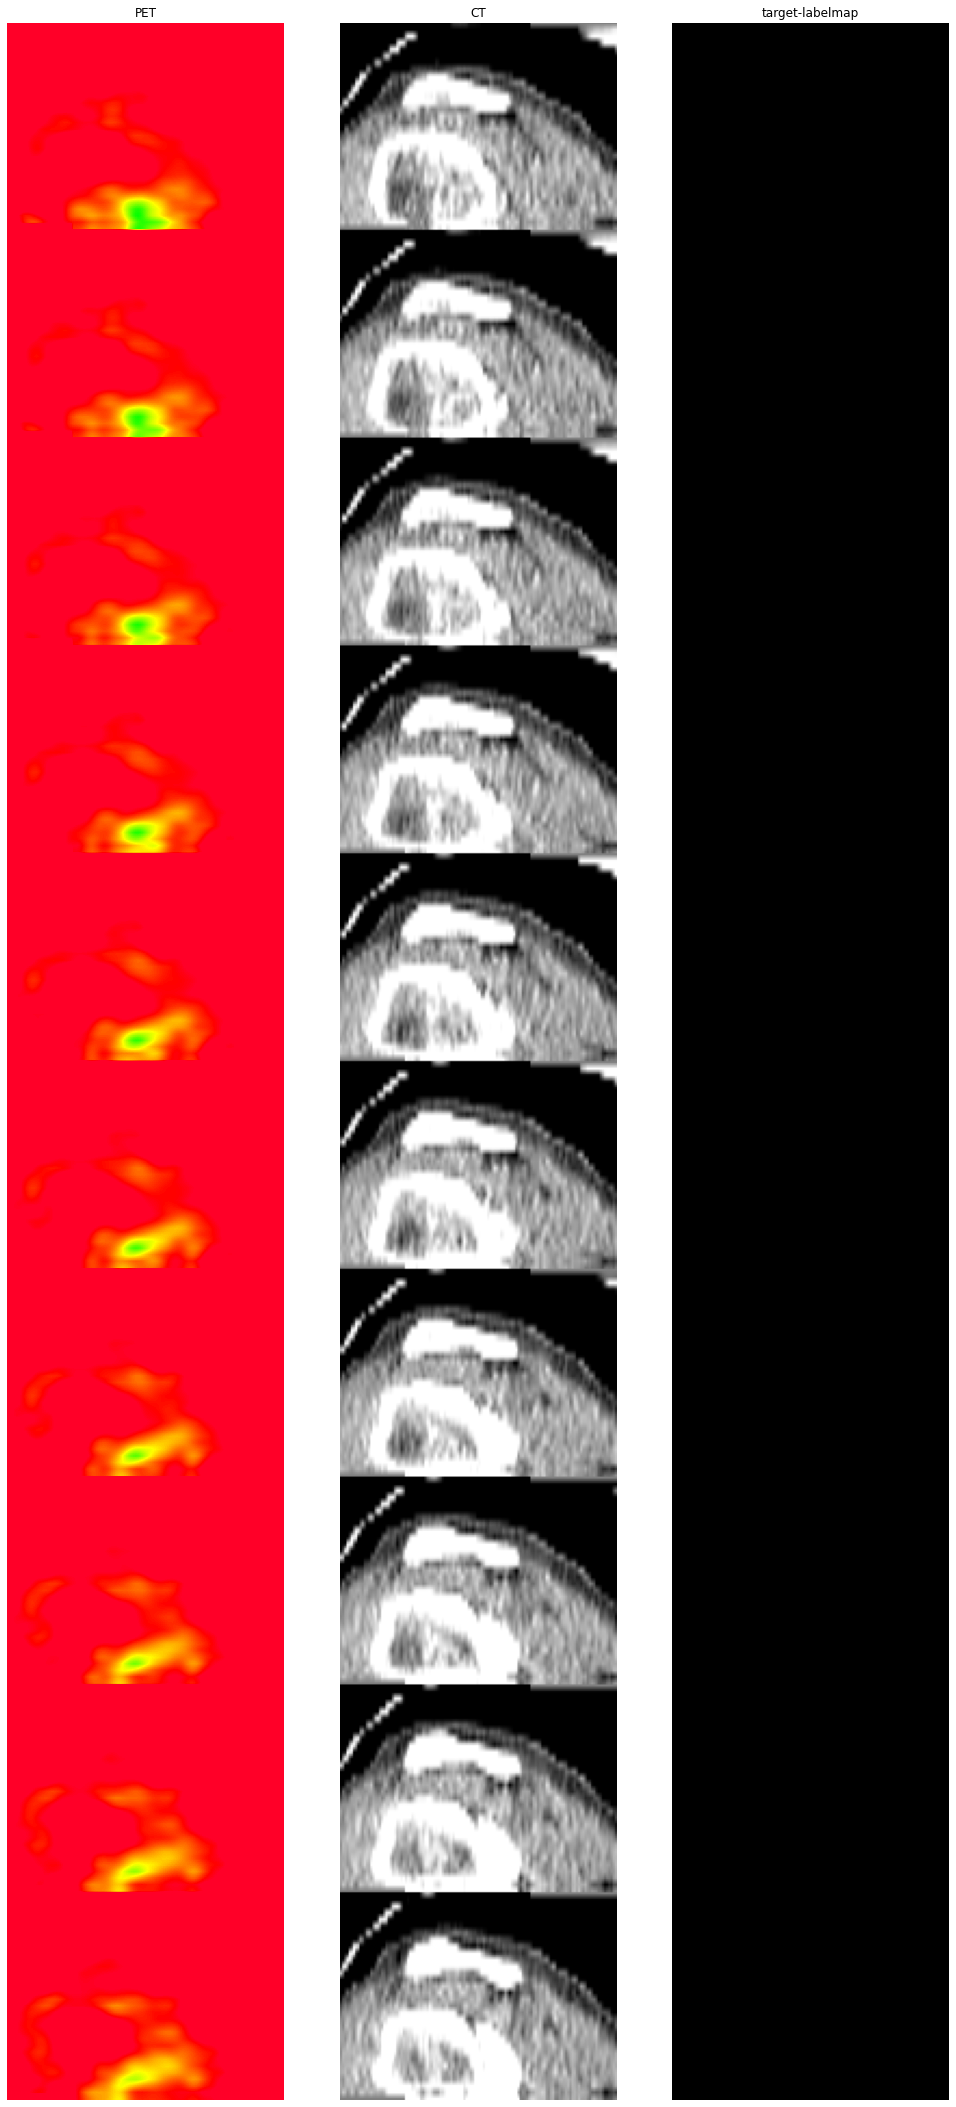

In [50]:
# Get sample 
patch_sample = patch_queue[3]
print(patch_sample.keys())
print(patch_sample['PET'].shape)

# Visualizing
PET_patch_np = patch_sample['PET'][0].permute(2,1,0).numpy()
CT_patch_np = patch_sample['CT'][0].permute(2,1,0).numpy()
target_labelmap_patch_np = patch_sample['target-labelmap'].permute(2,1,0).numpy()

viz.multi_image_strips([PET_patch_np, CT_patch_np, target_labelmap_patch_np],
                          modalities=['PET', 'CT', 'target-labelmap'],
                          idx_range=[0, 10],
                          view='axial',
                          subtitles=[])

## 3 Testing the patch loader

Batch: 1


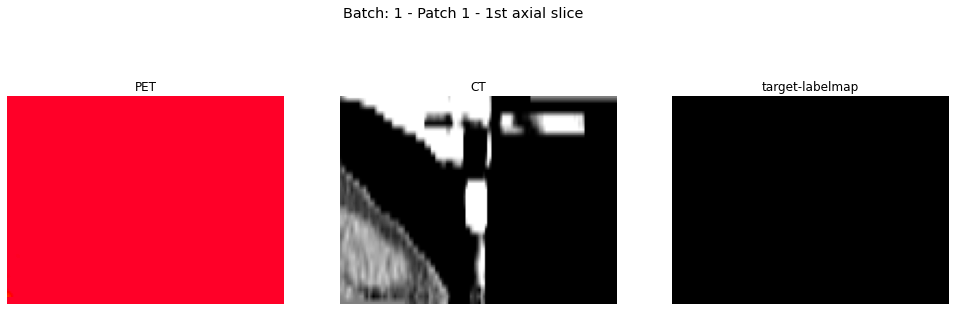

Batch: 2


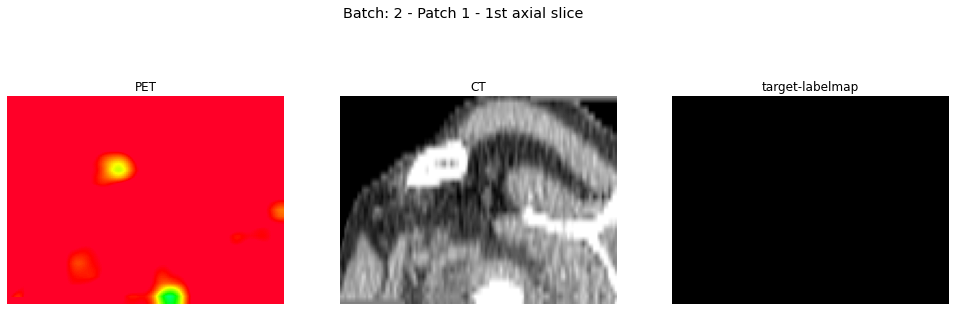

Batch: 3


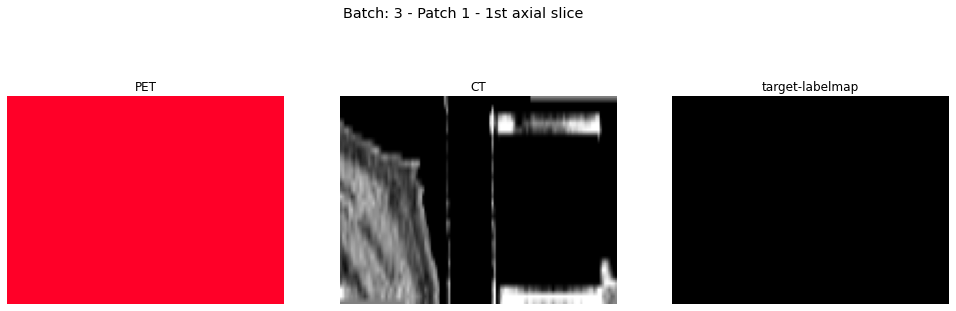

Batch: 4


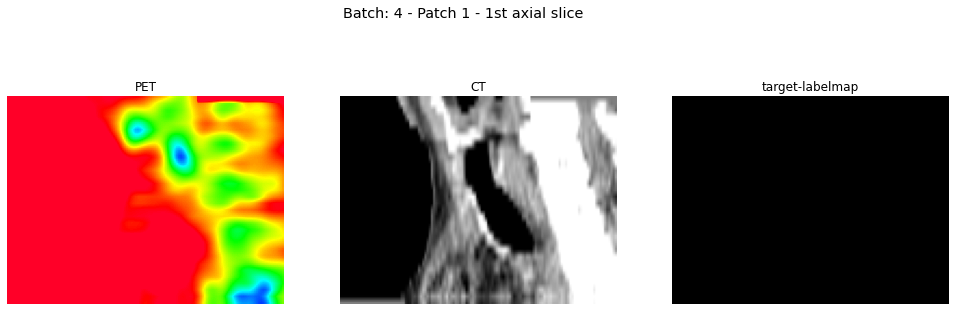

In [35]:
patch_loader = DataLoader(patch_queue, batch_size=4)

for i, batch_of_patches in enumerate(patch_loader):

    print(f"Batch: {i+1}")
    
    # Visualizing one slice of the 1st patch from this batch
    PET_patch_np = batch_of_patches['PET'][0][0].permute(2,1,0).numpy()
    CT_patch_np = batch_of_patches['CT'][0][0].permute(2,1,0).numpy()
    target_labelmap_patch_np = batch_of_patches['target-labelmap'][0].permute(2,1,0).numpy()

    viz.multi_image_strips([PET_patch_np, CT_patch_np, target_labelmap_patch_np],
                              modalities=['PET', 'CT', 'target-labelmap'],
                              idx_range=[0, 1],
                              view='axial',
                              subtitles=[],
                              title=f"Batch: {i+1} - Patch 1 - 1st axial slice")
    
    # Stop when the queue is empty. 
    # However, actual limit of the patch loader is 1 epoch, i.e. patient dataset length * samples_per_volume
    if i==3: break 